In [1]:
options(repos = c(CRAN = "https://cloud.r-project.org"))

if (!require("pacman")) install.packages("pacman")
pacman::p_load(tidyverse, ggplot2, dplyr, lubridate, stringr, readxl, data.table, gdata, scales, data.table)

Loading required package: pacman



In [2]:
data.2010 <- read.csv('../data/data-2010.csv')
data.2011 <- read.csv('../data/data-2011.csv')
data.2012 <- read.csv('../data/data-2012.csv')
data.2013 <- read.csv('../data/data-2013.csv')
data.2014 <- read.csv('../data/data-2014.csv')
data.2015 <- read.csv('../data/data-2015.csv')

In [3]:
fix_type <- function(df) {
  df$org_parent <- as.character(df$org_parent)
  df
}

data.2011 <- fix_type(data.2011)

In [12]:
data.full <- bind_rows(data.2010, data.2011, data.2012, data.2013, data.2014, data.2015)  %>%
  mutate(market_share = avg_enrollment / avg_enrolled)

# Problem 1

In [52]:
summary_table <- data.full %>%
  group_by(year) %>%
  summarise(
    'Average Star Rating' = round(mean(Star_Rating, na.rm = TRUE), 2),
    'Average Enrollments' = round(mean(avg_enrollment, na.rm = TRUE), 2),
    'Average Market Share' = round(mean(market_share, na.rm = TRUE), 4),
    'Total Number Of Plans' = n()
  )

print(summary_table)

# A tibble: 6 × 5
   year `Average Star Rating` `Average Enrollments` `Average Market Share`
  <int>                 <dbl>                 <dbl>                  <dbl>
1  2010                  2.97                  256.                 0.0658
2  2011                  3.26                  343.                 0.0855
3  2012                  3.36                  377.                 0.0856
4  2013                  3.55                  396.                 0.0815
5  2014                  3.81                  437.                 0.08  
6  2015                  3.96                  470.                 0.0787
# ℹ 1 more variable: `Total Number Of Plans` <int>


## Problem 2

In [53]:
without_rating_table <- data.full %>%
  filter(is.na(Star_Rating)) %>%
  group_by(year) %>%
  summarise(
    'Average Enrollments' = round(mean(avg_enrollment, na.rm = TRUE), 2),
    'Average Market Share' = round(mean(market_share, na.rm = TRUE), 4),
    'Total Number Of Plans' = n()
  )

print(without_rating_table)

# A tibble: 6 × 4
   year `Average Enrollments` `Average Market Share` `Total Number Of Plans`
  <int>                 <dbl>                  <dbl>                   <int>
1  2010                  107.                 0.0673                   48643
2  2011                  168.                 0.09                     12754
3  2012                  173.                 0.0567                    9077
4  2013                  214.                 0.06                      3661
5  2014                  258.                 0.0557                    3708
6  2015                  314.                 0.0405                    4680


## Problem 3

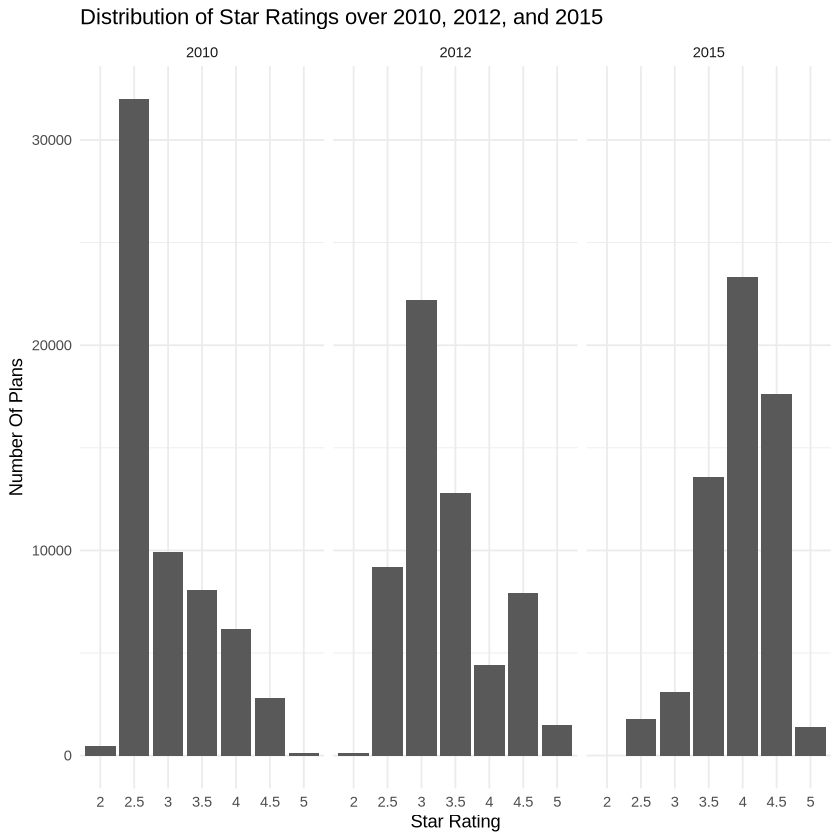

In [18]:
data.full %>%
  filter(year %in% c(2010, 2012, 2015), !is.na(Star_Rating)) %>%
  mutate(year = as.factor(year)) %>%
  ggplot(aes(x = as.factor(Star_Rating))) +
  geom_bar() +
  facet_wrap(~ year) +
  labs(
    title = "Distribution of Star Ratings over 2010, 2012, and 2015",
    x = "Star Rating",
    y = "Number Of Plans"
  ) +
  theme_minimal()

## Problem 4

In [33]:
data.full <- data.full %>%
  mutate(
    star_3   = as.integer(Star_Rating == 3),
    star_35  = as.integer(Star_Rating == 3.5),
    star_4   = as.integer(Star_Rating == 4),
    star_45  = as.integer(Star_Rating >= 4.5)
  )

estimate <- list()

for(yr in 2010:2015){
  ols <- lm(market_share ~ star_3 + star_35 + star_4 + star_45, 
            data = data.full %>% filter(year == yr, !is.na(Star_Rating), !is.na(market_share)))
  results_list[[as.character(yr)]] <- coef(ols)
}

ols_table <- as.data.frame(results_list)
colnames(ols_table) <- c("2010", "2011", "2012", "2013", "2014", "2015")
rownames(ols_table) <- c("Excluded (<= 2.5 stars)", "3 Stars", "3.5 Stars", "4 Stars", ">= 4.5 Stars")

print(round(ols_table, 4))

                           2010    2011    2012   2013   2014   2015
Excluded (<= 2.5 stars)  0.0634  0.0702  0.0789 0.0491 0.0640 0.0606
3 Stars                  0.0126  0.0350  0.0307 0.0621 0.0267 0.0271
3.5 Stars                0.0005  0.0191  0.0129 0.0385 0.0273 0.0388
4 Stars                 -0.0036  0.0028 -0.0246 0.0172 0.0074 0.0115
>= 4.5 Stars            -0.0076 -0.0095 -0.0134 0.0222 0.0071 0.0233


## Problem 5

In [48]:
quality_vars <- c(
  "breastcancer_screen",
  "rectalcancer_screen",
  "cv_diab_cholscreen",
  "glaucoma_test",
  "monitoring",
  "flu_vaccine",
  "pn_vaccine",
  "physical_health",
  "mental_health",
  "osteo_test",
  "physical_monitor",
  "primaryaccess",
  "osteo_manage",
  "diab_healthy",
  "bloodpressure",
  "ra_manage",
  "copd_test",
  "bladder",
  "falling",
  "nodelays",
  "doctor_communicate",
  "carequickly",
  "customer_service",
  "overallrating_care",
  "overallrating_plan",
  "complaints_plan",
  "appeals_timely",
  "appeals_review",
  "leave_plan",
  "audit_problems",
  "hold_times",
  "info_accuracy",
  "ttyt_available"
)

library(dplyr)

data.2010 <- data.2010 %>%
  rowwise() %>%
  mutate(
    raw_rating = mean(c_across(all_of(quality_vars)), na.rm = TRUE)
  ) %>%
  ungroup()

In [54]:
round_up_counts <- data.2010 %>%
  filter(!is.na(raw_rating)) %>%
  filter(!is.na(partc_score)) %>%
  mutate(
    round_ups = case_when(
      raw_rating >= 2.75 & partc_score == 3.0  ~ "Rounded up to 3",
      raw_rating >= 3.25 & partc_score == 3.5  ~ "Rounded up to 3.5",
      raw_rating >= 3.75 & partc_score == 4.0  ~ "Rounded up to 4",
      raw_rating >= 4.25 & partc_score == 4.5  ~ "Rounded up to 4.5",
      raw_rating >= 4.75 & partc_score == 5.0  ~ "Rounded up to 5",
      TRUE ~ NA_character_
    )
  ) %>%
  filter(!is.na(round_ups)) %>%
  count(round_ups) %>%
  rename('Star Rating' = round_ups, 'Corresponding Number Of Plans' = n)

print(round_up_counts)

# A tibble: 5 × 2
  `Star Rating`     `Corresponding Number Of Plans`
  <chr>                                       <int>
1 Rounded up to 3                              9918
2 Rounded up to 3.5                            8091
3 Rounded up to 4                              4284
4 Rounded up to 4.5                             771
5 Rounded up to 5                                30
